Install Neptune client


In [0]:
pip install neptune-client

Import `neptune` library and initialize tracking.

I created a public project `shared/colab-test-run` where you can log as anonymous user neptuner (just use `api_token="ANONYMOUS"`).

Normally you need to pass your private `api_token` and the name of your  project.


In [4]:
import neptune

neptune.init(
    api_token="ANONYMOUS",
    project_qualified_name="shared/colab-test-run"
)

Project(shared/colab-test-run)

# Basic Example

Lets start with something super simple.

I will:
 create an experiment, add a tag, and send a metric value

* create an experiment
* log hyperparameters
* log a metric
* append a tag
* stop experiment



In [5]:
neptune.create_experiment(
    name='basic-colab-example',
    params={'learning_rate':0.1}
)

neptune.log_metric('accuracy', 0.93)

neptune.append_tags(['basic', 'finished_successfully'])

neptune.stop()

https://ui.neptune.ai/shared/colab-test-run/e/COL-8


If you floow the link above you should see something like this: 

![alt text](https://neptune.ai/wp-content/uploads/Screenshot-from-2020-03-18-11-58-14.png)

You can change the values and rerun to see those appear in the dashboard.
All `basic-colab-example` experiments are grouped in [this dashboard view](https://ui.neptune.ai/o/shared/org/colab-test-run/experiments?viewId=8dbc02b5-c68c-4833-9b43-828678145442).

There are many other things that you can log to neptune:

* Images and charts
* Artifacts like model weights or results
* Text values
* Hardware consumption
* Code snapshots
* and more

You can go and see all that in the [documentation](https://docs.neptune.ai/python-api/introduction.html) but you can check out the next example to see some of those.

# Keras classification example

Install and import your machine learning libraries

In [0]:
pip install keras scikit-plot

Get the data:

In [0]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

To log metrics after every batch and epoch let's create `NeptuneLogger` callback:

In [0]:
from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}):
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}):
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)

Now we simply need to create an experiment. 
I will tag it with the name `advanced` and log hyperparameters `epoch_nr` and `batch_size`: 

In [41]:
EPOCH_NR = 6
BATCH_SIZE = 32

neptune.create_experiment(name='keras-metrics',
                          params={'epoch_nr': EPOCH_NR,
                                  'batch_size': BATCH_SIZE},
                          tags=['advanced'],
                          )

https://ui.neptune.ai/shared/colab-test-run/e/COL-11


Experiment(COL-11)

Now we pass our `NeptuneLogger` as keras callback and thats it.

In [42]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=EPOCH_NR,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    callbacks=[NeptuneLogger()])

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 10s 169us/sample - loss: 0.6351 - acc: 0.8340 - val_loss: 0.3456 - val_acc: 0.9088
Epoch 2/6
60000/60000 [==============================] - 9s 148us/sample - loss: 0.3436 - acc: 0.9031 - val_loss: 0.2789 - val_acc: 0.9236
Epoch 3/6
60000/60000 [==============================] - 9s 145us/sample - loss: 0.2906 - acc: 0.9185 - val_loss: 0.2454 - val_acc: 0.9320
Epoch 4/6
60000/60000 [==============================] - 9s 148us/sample - loss: 0.2563 - acc: 0.9273 - val_loss: 0.2191 - val_acc: 0.9394
Epoch 5/6
60000/60000 [==============================] - 9s 145us/sample - loss: 0.2308 - acc: 0.9353 - val_loss: 0.1991 - val_acc: 0.9452
Epoch 6/6
60000/60000 [==============================] - 9s 144us/sample - loss: 0.2093 - acc: 0.9413 - val_loss: 0.1840 - val_acc: 0.9482


You can click on the experiment link above and monitor your learning curves as it is training!

![alt text](https://neptune.ai/wp-content/uploads/monitor_training.png)

Great thing is, you can log more things if you need to during or after the training is finished.

For example, let's calculate some additional metrics on test data and log them.

In [0]:
import numpy as np

y_test_pred = np.asarray(model.predict(x_test))
y_test_pred_class = np.argmax(y_test_pred, axis=1)

In [0]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_test_pred_class, average='micro')

neptune.log_metric('test_f1', f1)

We can log diagnostic charts like confusion matrix or ROC AUC curve.

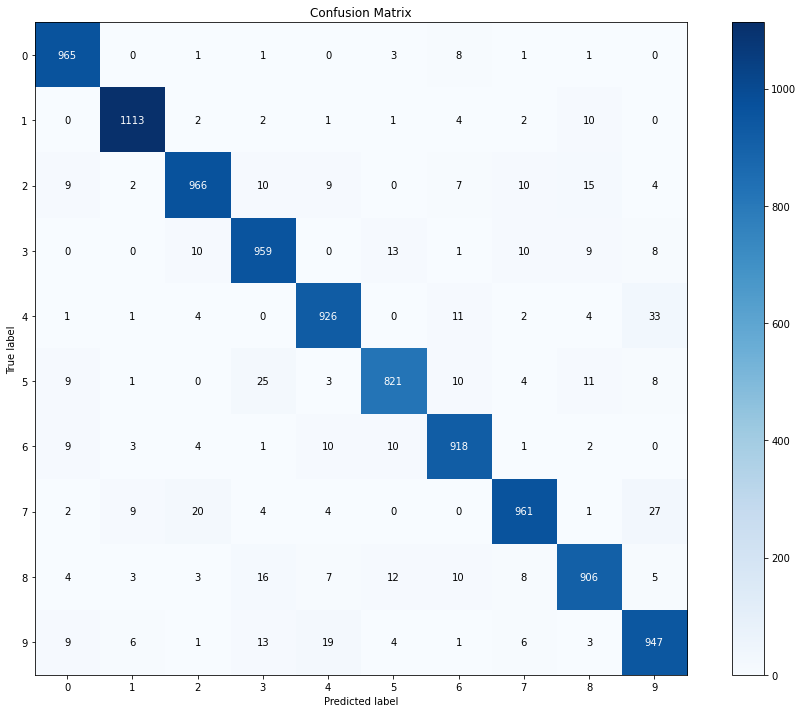

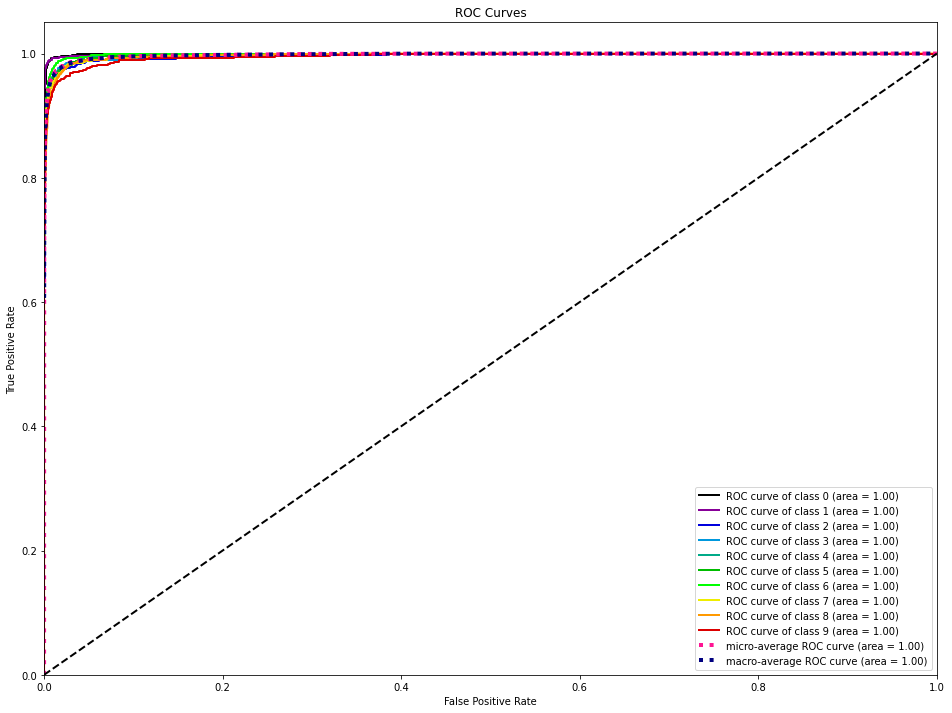

In [45]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc

fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_test, y_test_pred_class, ax=ax)
neptune.log_image('diagnostic_charts', fig)

fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_test, y_test_pred, ax=ax)
neptune.log_image('diagnostic_charts', fig)

![alt text](https://neptune.ai/wp-content/uploads/logging_charts.png)

We can also log model weights to Neptune.

In [0]:
model.save('my_model.h5')
neptune.log_artifact('my_model.h5')

![alt text](https://neptune.ai/wp-content/uploads/logging_artifacts.png)

With that you can share models with your teammates easily.

Once we are done logging we should remember to stop the experiment.

In [0]:
neptune.stop()

You can play around and run this experiment with different parameters and see results and compare them.

Like I've done [here](https://ui.neptune.ai/o/shared/org/colab-test-run/compare?shortId=%5B%22COL-11%22%2C%22COL-10%22%2C%22COL-9%22%2C%22COL-6%22%5D&viewId=f93b0ebd-6c75-4862-96f3-df1a67c08ea9&chartFilter=epoch_val_acc&legendFields=%5B%22shortId%22%2C%22epoch_val_acc%22%2C%22epoch_val_loss%22%2C%22epoch_loss%22%2C%22epoch_acc%22%5D&legendFieldTypes=%5B%22native%22%2C%22numericChannels%22%2C%22numericChannels%22%2C%22numericChannels%22%2C%22numericChannels%22%5D):

![alt text](https://neptune.ai/wp-content/uploads/exp_comparison-1.png)

A cool thing is, once things are logged to Neptune you can access them from wherever you want.
Let me show you. 

# Access data you logged programatically 

Neptune lets you fetch whatever you logged to it directly to your notebooks and scripts.

Just run:

In [18]:
from neptune import Session

session = Session.with_default_backend(api_token="ANONYMOUS")
my_project = session.get_project("shared/colab-test-run")

Now that your project is *fetched* you can download the experiment dashboard data.

I will download only the experiment data with the `tag="advanced"` :

In [19]:
my_project.get_leaderboard(tag=['advanced']).head()

,id,name,created,finished,owner,notes,running_time,size,tags,channel_batch_acc,channel_batch_batch,channel_batch_loss,channel_batch_size,channel_epoch_acc,channel_epoch_loss,channel_epoch_val_acc,channel_epoch_val_loss,channel_external_validation_accuracy,channel_test_f1,parameter_batch_size,parameter_epoch_nr
0,COL-6,keras-metrics,2020-03-18 13:48:57.634000+00:00,2020-03-18 13:53:03.699000+00:00,neptuner,,246,4604159,[advanced],0.9346166849136353,1874.0,0.1260441243648529,32.0,0.9346166849136353,0.23210642515420915,0.9434999823570251,0.20139242940545082,0.82,0.9435,32.0,20.0
1,COL-9,keras-metrics,2020-03-18 14:06:42.294000+00:00,2020-03-18 14:13:34.798000+00:00,neptuner,,412,4613992,[advanced],0.9347500205039978,1874.0,0.12625783681869507,32.0,0.9347500205039978,0.2352248264034589,0.9426000118255615,0.2028423045039177,NaN,0.9426,32.0,5.0


You can also access information from the individual experiment:

In [20]:
exp = my_project.get_experiments(id='COL-6')[0]
exp

Experiment(COL-6)

In [21]:
exp.get_numeric_channels_values("epoch_loss", "epoch_val_loss")

,x,epoch_val_loss,epoch_loss
0,0.0,0.343443,0.639181
1,1.0,0.279858,0.345489
2,2.0,0.246791,0.292363
3,3.0,0.221676,0.257040
4,4.0,0.201392,0.232106


You can even download artifacts from that experiment if you want to:



In [0]:
exp.download_artifact('my_model.h5','./')

In [24]:
ls ./

my_model.h5  sample_data/



# Learn more about Neptune

Read about other Neptune features, create your free account and start logging!

[**Go to Neptune**](https://neptune.ai/experiment-tracking?utm_source=colab&utm_medium=notebook&utm_campaign=colab-examples&utm_content=test-run)
